### Initialization
---

I ran this notebook on Python 3.10.11. All packages were installed using pip for package management.

In [1]:
import torch
import torchvision.transforms.v2 as transforms
import torchvision.models as models
import torchvision
import numpy as np
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision.models.feature_extraction import create_feature_extractor
from sklearn.model_selection import KFold
from PIL import Image
import glob
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn
import pandas as pd
import re

FOLDER variable has the format of:

FOLDER
* sectname_year.csv
* sections [folder]
    * original [folder]
        * samples used for prediction
    * equalized [folder]
        * samples used for prediction

In [ ]:
RNG = np.random.default_rng()
DEVICE = torch.device("cuda" if (torch.cuda.is_available()) else 'cpu')

# Failures is all of the seven possible failures that came with the excel data
FAILURES = ["erosion", "checking", "cracking", "flaking", "peeling", "chalking", "mildew/algae"]

# predicted failures are the failures that are predicted by the models, this is adjusted in compile_samples
# this done due to the new samples not having the same number of labels as the original samples
# if the new samples are included then we predict these 4, otherwise, we predict all 7.
PREDICTED_FAILURES = ["cracking", "flaking", "chalking", "mildew/algae"]


# Folder has the format of 
# FOLDER
#   ->  sectname_year.csv
#   ->  sections [folder]
#       ->  original [folder]
#           ->  samples used for prediction
#       -> equalized [folder]
#           -> samples used for prediction
FOLDER = "G:/My Drive/Arkema Notes/Arkema_Local/arkema_panel_splitter"

BATCH_SIZE = 16
print(DEVICE)

### Dataset Generation
---

#### Compile Samples

In [82]:
def compile_samples(include_new:bool=False):
    '''
    Compiles all of the sample names into a list to build the dataset.

    Keywords:
        include_new [bool] - if True, uses all samples including the newly acquired samples
    '''
    global PREDICTED_FAILURES
    global FOLDER

    files = glob.glob(f"{FOLDER}/sections/original/*.JPG") # collect all files
    removed_samples = [] # 

    for i, f in enumerate(files):
        # print(re_match.group(0))
        panel_title = f.split("\\")[-1][:-4] # get the panel title
        section_num = panel_title[:-5] # get the section number
        files[i] = section_num # change the file name to the section number ONLY. This is done to avoid data leakage (all years go to same dataset).
        if (not include_new) and ("S1307024" in section_num): # if this data is the new 2024 data and we do not want to include it
            removed_samples.append(i) # append it for removal after processing

    PREDICTED_FAILURES = ["cracking", "flaking"] if include_new else ["cracking", "flaking", "chalking", "mildew/algae"] # since we only have 4 labels for the new samples, this determines what we are predicting

    for i in reversed(removed_samples): # delete the extra samples
        files.pop(i)

    file_names = list(set(files))
    print(*file_names, end="\n")
    return file_names

In [83]:
def clean_array(array):
    '''
    Used to remove the rare case of samples that contain labels marked by "--".
    
    Keywords:
        array [np.array] - the array to be cleaned of any weird labels that are not numbers.
    '''
    for i, val in enumerate(array):
        if val == "--":
            array[i] = 0
        if isinstance(val, str):
            if val[-1].isalpha():
                array[i] = val[:-1]
            array[i] = float(array[i])
    return array

In [118]:
def make_sample_splits(file_names, split_percents=[.85,.1,.05]):
    '''
    Randomly splits the samples into the 3 datasets: train, test, and validation.

    Keywords:
        file_names [list[str]] - list of the file_names that should be split into the datasets (comes directly from compile_samples).
        split_percents [list[float]] - list of the split percents in order of [train_percent, test_percent, validation percent].
    '''
    global FOLDER
    train_pct, test_pct, val_pct = split_percents

    # initialize lists to go into datasets
    train_files = []
    test_files = []
    val_files = []

    # initial lists of the labels for the dataset
    train_labels = np.array([])
    test_labels = np.array([])
    val_labels = np.array([])

    rnd_idxs = np.random.choice([0,1,2], size=len(file_names), p=(train_pct, test_pct, val_pct), replace=True) # generate a random value in range [0,2] with each value's respective likelihood from split_percents

    for i, idx in enumerate(rnd_idxs):
        file_set = glob.glob(f"{FOLDER}/sections/original/{file_names[i]}*.JPG") # get files that match by section ID (every year that has same ID)

        # get information about the file
        section_name = file_names[i][1:8]
        panel_name = file_names[i][9:]
        years = [fi[-8:-4] for fi in file_set] # all year possibilities for given section
        
        # index 0 = train, index 1 = test, index 2 = validation
        if idx==0:
            train_files += file_set
            for year in years:
                # get labels for each year
                data_csv = pd.read_csv(f"{FOLDER}/{section_name}_{year}.csv") # read the csv for that year
                data = data_csv.set_index("PnlSec") # get the panel+section together
                panel_label = data.loc[panel_name].values # collect the values based on the panel name
                panel_label = clean_array(panel_label) # clean it to get rid of any "--" labels
                train_labels = np.concatenate((train_labels, np.array(panel_label))) # add all labels to the label set

        elif idx==1:
            test_files += file_set
            for year in years:
                data_csv = pd.read_csv(f"{FOLDER}/{section_name}_{year}.csv")
                data = data_csv.set_index("PnlSec")
                panel_label = data.loc[panel_name].values
                panel_label = clean_array(panel_label)
                test_labels = np.concatenate((test_labels, np.array(panel_label)))

        else:
            val_files += file_set
            for year in years:
                data_csv = pd.read_csv(f"{FOLDER}/{section_name}_{year}.csv")
                data = data_csv.set_index("PnlSec")
                panel_label = data.loc[panel_name].values
                panel_label = clean_array(panel_label)
                val_labels = np.concatenate((val_labels, np.array(panel_label)))

    # reshape all labels to contain all 7 possible failures per sample
    train_labels = train_labels.reshape(-1,7).astype(np.float64)
    test_labels = test_labels.reshape(-1,7).astype(np.float64)
    val_labels = val_labels.reshape(-1,7).astype(np.float64)

    print("Train Labels Shape:", train_labels.shape)
    print("Test Labels Shape:", test_labels.shape)
    print("Val Labels Shape:", val_labels.shape)

    return train_files, train_labels, test_files, test_labels, val_files, val_labels

In [ ]:
# generate dataset information
file_names = compile_samples(include_new=False)
train_files, train_labels, test_files, test_labels, val_files, val_labels = make_sample_splits(file_names)

#### 1st and 2nd Order Functions

In [120]:
# collecting the first order statistics
def mean(img):
    img_arr = img.astype(float)
    img_arr = (img_arr - np.min(img_arr)) / (np.max(img_arr) - np.min(img_arr))
    return np.mean(img_arr)

def variance(img):
    img_arr = img.astype(float)
    img_arr = (img_arr - np.min(img_arr)) / (np.max(img_arr) - np.min(img_arr))
    return np.var(img_arr)

def energy(img):
    img_arr = img.astype(float)
    img_arr = (img_arr - np.min(img_arr)) / (np.max(img_arr) - np.min(img_arr))
    return np.mean(img_arr**2)

In [121]:
def GLCM(img, angle=0, normalized=True):
    '''
    Calculates the Gray-Level Co-Occurence Matrix for a given image.

    Keywords:
        img [np.array] - the image to convert to a GLCM.
        angle [int] - the direction of the view window as it goes across.
        normalized [bool] - if true, normalizing the GLCM to have all values between 0 and 1.
    '''
    if angle not in [0, 45, 90, 135]:
        raise ValueError("angle parameter must be 0, 45, 90, or 135")

    min_pix = np.min(img)
    img_arr = img - min_pix # subtract out the minimum pixel intensity
    img_arr = np.digitize(img_arr, np.linspace(0, 256, 16)) # quantize image (necessary for getting decent outputs)
    img_arr = img_arr.astype(int)
    max_pix = np.max(img_arr)

    GLCM_array = np.zeros((max_pix+1,max_pix+1)) # make matrix of appropriate size
    match angle:
        case 0:
            x_coord = img_arr[:,:-1].reshape(-1)
            y_coord = img_arr[:,1:].reshape(-1)

        case 45:
            x_coord = img_arr[1:,:-1].reshape(-1)
            y_coord = img_arr[:-1,1:].reshape(-1)

        case 90:
            x_coord = img_arr[1:,:].reshape(-1)
            y_coord = img_arr[:-1,:].reshape(-1)

        case 135:
            x_coord = img_arr[1:,1:].reshape(-1)
            y_coord = img_arr[:-1,:-1].reshape(-1)

    for i in range(len(x_coord)):
        GLCM_array[x_coord[i], y_coord[i]] += 1

    if normalized:
        return GLCM_array / (img_arr.shape[0]*img_arr.shape[1])

    return GLCM_array

In [122]:
def NGLDM(img, kernel_size=3):
    '''
    Calculates the Neighboring Gray-Level Dependence Matrix for a given image.

    Keywords:
        img [np.array] - the image to convert to a GLCM.
        kernel_size [int] - size of the neighborhood kernel.
    '''
    padding_size = kernel_size//2
    NGLDM_num = kernel_size**2 - 1 # max number of possible matches (in a kernel of KxK, the number of possible matches is K^2-1 because the center pixel always matches)

    min_pix = np.min(img)
    img_arr = img - min_pix # subtract out the minimum pixel intensity
    img_arr = np.digitize(img_arr, np.linspace(0, 256, 16)) # quantize image (necessary for getting decent outputs)

    img_arr = img_arr.astype(int)
    max_pix = np.max(img_arr)

    NGLDM_array = np.zeros((max_pix+1, NGLDM_num+1))

    for x in range(padding_size, len(img_arr)-padding_size): # iterate through all centers in the x direction
        for y in range(padding_size, len(img_arr[x])-padding_size): # iterate through all centers in the y direction
            cen_pix = img_arr[x,y]
            kernel = img_arr[x-padding_size:x+padding_size+1,y-padding_size:y+padding_size+1]

            num_sim = np.sum(kernel==cen_pix)-1 # calculate the number of pixels that match center pixel in kernel
            NGLDM_array[cen_pix, num_sim] += 1

    return NGLDM_array / (img_arr.shape[0]*img_arr.shape[1])

In [123]:
# collecting the second order statistics using the above functions
def angular_second_moment(GLCM_array):
    return np.sum(GLCM_array**2)

def contrast(GLCM_array):
    contrast_val = 0

    for n in range(len(GLCM_array)):
        for p in range(len(GLCM_array)):
            for q in range(len(GLCM_array[p])):
                if abs(p-q)==n:
                    contrast_val += (n**2 * GLCM_array[p,q])
    return contrast_val

def second_moment(NGLDM_array):
    tot = np.sum(NGLDM_array)
    return np.sum(NGLDM_array**2) / tot if (tot>0) else 0

#### Datasets & Dataloader

In [ ]:
class FullPanelDataset(Dataset):
    '''
    Dataset for the panel images, no augmentations applied. The tranformations made to each image follow this: https://pytorch.org/vision/main/models/generated/torchvision.models.vgg19.html#torchvision.models.vgg19
    
    Keywords:
        files [list[str]]: the set of files to build the dataset
        labels [np.array]: the array of labels to match the files
    '''
    def __init__(self, files, labels):
        super(FullPanelDataset, self).__init__()

        labels = torch.tensor(labels)
        self.dataset = torch.zeros((len(files), 3, 224, 224)) # due to the small size of this dataset, the dataset is STORED ON MEMORY, this makes training time much faster at the cost of more memory usage
        self.labels = torch.zeros((len(files), 7)) # due to the small size of this dataset, the dataset is STORED ON MEMORY, this makes training time much faster at the cost of more memory usage
        
        self.transform = transforms.Compose([
            transforms.Resize((256,256)),
            transforms.CenterCrop((224,224)),
            transforms.ToDtype(torch.float32, scale=True),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        for f, file in enumerate(files):
            img_arr = plt.imread(file)
            img_arr = np.transpose(img_arr, (2,0,1))
            img_arr = torch.tensor(img_arr)
            self.dataset[f] = self.transform(img_arr)
            self.labels[f] = labels[f]

        self.dataset = self.dataset.type(torch.float32)
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx:int):
        return self.dataset[idx], self.labels[idx]

In [125]:
class RandomCropPanelDataset(Dataset):
    '''
    Dataset for the randomly cropped panel images.
    
    Keywords:
        files [list[str]]: the set of files to build the dataset
        labels [np.array]: the array of labels to match the files
    '''
    def __init__(self, files, labels):
        super(RandomCropPanelDataset, self).__init__()

        labels = torch.tensor(labels)
        self.dataset = torch.zeros((len(files)*5, 3, 224, 224)) # due to the small size of this dataset, the dataset is STORED ON MEMORY, this makes training time much faster at the cost of more memory usage
        self.labels = torch.zeros((len(files)*5, 7)) # due to the small size of this dataset, the dataset is STORED ON MEMORY, this makes training time much faster at the cost of more memory usage
        
        self.transform = transforms.Compose([
            transforms.RandomCrop((50,50)),
            transforms.Resize((256,256)),
            transforms.CenterCrop((224,224)),
            transforms.ToDtype(torch.float32, scale=True),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        for f, file in enumerate(files):
            img_arr = plt.imread(file)
            img_arr = np.transpose(img_arr, (2,0,1))
            img_arr = torch.tensor(img_arr)
            for i in range(5):
                self.dataset[f*5+i] = self.transform(img_arr)
                self.labels[f*5+i] = labels[f]

        self.dataset = self.dataset.type(torch.float32)
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx:int):
        return self.dataset[idx], self.labels[idx]

In [126]:
class FiveCropPanelDataset(Dataset):
    '''
    Dataset for the five cropped panel images. The five crops are top left, top right, bottom left, bottom right, and center
    
    Keywords:
        files [list[str]]: the set of files to build the dataset
        labels [np.array]: the array of labels to match the files
    '''
    def __init__(self, files, labels):
        super(FiveCropPanelDataset, self).__init__()

        labels = torch.tensor(labels)
        self.dataset = torch.zeros((len(files)*5, 3, 224, 224)) # due to the small size of this dataset, the dataset is STORED ON MEMORY, this makes training time much faster at the cost of more memory usage
        self.labels = torch.zeros((len(files)*5, 7)) # due to the small size of this dataset, the dataset is STORED ON MEMORY, this makes training time much faster at the cost of more memory usage

        self.transform = transforms.Compose([
            transforms.Resize((256,256)),
            transforms.CenterCrop((224,224)),
            transforms.ToDtype(torch.float32, scale=True),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        for f, file in enumerate(files):
            img_arr = plt.imread(file)
            img_arr = np.transpose(img_arr, (2,0,1))
            img_arr = torch.tensor(img_arr)

            tl, tr, bl, br, cen = transforms.FiveCrop(size=(50,50))(img_arr)

            self.dataset[f*5] = self.transform(tl)
            self.dataset[f*5+1] = self.transform(tr)
            self.dataset[f*5+2] = self.transform(bl)
            self.dataset[f*5+3] = self.transform(br)
            self.dataset[f*5+4] = self.transform(cen)

            self.labels[f*5:f*5+4] = labels[f]
        
        self.dataset = self.dataset.type(torch.float32)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx:int):
        return self.dataset[idx], self.labels[idx]

In [127]:
class PanelStasticsDatasetFromFiles(Dataset):
    '''
    Dataset for the panel statistics. Relies on the files to generate dataset. This dataset uses only 6 statistics generated from the image.
    THIS IS NOT USED, BUT MAY BE USEFUL TO SOMEONE.
    
    Keywords:
        files [list[str]]: the set of files to build the dataset
        labels [np.array]: the array of labels to match the files
    '''
    def __init__(self, files, labels):
        super(PanelStasticsDatasetFromFiles, self).__init__()
        
        self.dataset = torch.zeros((len(files), 6))
        self.labels = torch.tensor(labels)

        for f, file in enumerate(files):
            img_arr = plt.imread(file)

            cen_x = img_arr.shape[0]//2
            cen_y = img_arr.shape[1]//2
            img_arr = img_arr[cen_x-50:cen_x+50, cen_y-50:cen_y+50]

            mu = mean(img_arr)
            var = variance(img_arr)
            enrgy = energy(img_arr)

            img_arr = .299*img_arr[:,:,0] + .587*img_arr[:,:,1] + .114*img_arr[:,:,2] # convert to single channel

            GLCM_array = GLCM(img_arr)
            NGLDM_array = NGLDM(img_arr)

            asm = angular_second_moment(GLCM_array)
            cont = contrast(GLCM_array)
            sm = second_moment(NGLDM_array)

            self.dataset[f] = torch.tensor([mu, var, enrgy, asm, cont, sm])

        self.dataset = (self.dataset - self.dataset.mean(dim=1, keepdim=True)) / (self.dataset.std(dim=1, keepdim=True))

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx:int):
        return self.dataset[idx], self.labels[idx]

In [128]:
class PanelStasticsDataset(Dataset):
    '''
    Dataset for the panel statistics. Relies on other datasets to generate this dataset. This dataset uses only 6 statistics generated from the image.
    
    Keywords:
        dataset [Dataset]: the dataset to build samples from
        labels [np.array]: the array of labels to match the files
    '''
    def __init__(self, dataset: Dataset):
        super(PanelStasticsDataset, self).__init__()
        
        self.dataset = torch.zeros((len(dataset), 6))
        self.labels = dataset.labels

        for i, img in enumerate(dataset.dataset):
            img_arr = np.transpose(img, (2,0,1))
            img_arr = img_arr.numpy()

            cen_x = img_arr.shape[0]//2
            cen_y = img_arr.shape[1]//2
            img_arr = img_arr[cen_x-50:cen_x+50, cen_y-50:cen_y+50]

            mu = mean(img_arr)
            var = variance(img_arr)
            enrgy = energy(img_arr)

            img_arr = .299*img_arr[:,:,0] + .587*img_arr[:,:,1] + .114*img_arr[:,:,2]

            GLCM_array = GLCM(img_arr)
            NGLDM_array = NGLDM(img_arr)

            asm = angular_second_moment(GLCM_array)
            cont = contrast(GLCM_array)
            sm = second_moment(NGLDM_array)

            self.dataset[i] = torch.tensor([mu, var, enrgy, asm, cont, sm])

        self.dataset = (self.dataset - self.dataset.mean(dim=1, keepdim=True)) / (self.dataset.std(dim=1, keepdim=True))

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx:int):
        return self.dataset[idx], self.labels[idx]

#### Dataset Building

##### Datasets for VGG19 Models

In [129]:
train_full_ds = FullPanelDataset(train_files, train_labels)
test_full_ds = FullPanelDataset(test_files, test_labels)
val_full_ds = FullPanelDataset(val_files,val_labels)

train_random_crop_ds = RandomCropPanelDataset(train_files, train_labels)
test_random_crop_ds = RandomCropPanelDataset(test_files, test_labels)
val_random_crop_ds = RandomCropPanelDataset(val_files, val_labels)

train_five_crop_ds = FiveCropPanelDataset(train_files, train_labels)
test_five_crop_ds = FiveCropPanelDataset(test_files, test_labels)
val_five_crop_ds = FiveCropPanelDataset(val_files, val_labels)

##### Datasets for Statistical Models

In [130]:
train_statistics_full_ds = PanelStasticsDataset(train_full_ds)
test_statistics_full_ds = PanelStasticsDataset(test_full_ds)
val_statistics_full_ds = PanelStasticsDataset(val_full_ds)

train_statistics_random_crop_ds = PanelStasticsDataset(train_random_crop_ds)
test_statistics_random_crop_ds = PanelStasticsDataset(test_random_crop_ds)
val_statistics_random_crop_ds = PanelStasticsDataset(val_random_crop_ds)

train_statistics_five_crop_ds = PanelStasticsDataset(train_five_crop_ds)
test_statistics_five_crop_ds = PanelStasticsDataset(test_five_crop_ds)
val_statistics_five_crop_ds = PanelStasticsDataset(val_five_crop_ds)

##### All Dataloader Generation

In [131]:
train_full_loader = DataLoader(train_full_ds, batch_size=BATCH_SIZE, shuffle=True)
test_full_loader = DataLoader(test_full_ds, batch_size=BATCH_SIZE)
val_full_loader = DataLoader(val_full_ds, batch_size=BATCH_SIZE)

train_random_crop_loader = DataLoader(train_random_crop_ds, batch_size=BATCH_SIZE, shuffle=True)
test_random_crop_loader = DataLoader(test_random_crop_ds, batch_size=BATCH_SIZE)
val_random_crop_loader = DataLoader(val_random_crop_ds, batch_size=BATCH_SIZE)

train_five_crop_loader = DataLoader(train_five_crop_ds, batch_size=BATCH_SIZE, shuffle=True)
test_five_crop_loader = DataLoader(test_five_crop_ds, batch_size=BATCH_SIZE)
val_five_crop_loader = DataLoader(val_five_crop_ds, batch_size=BATCH_SIZE)

In [132]:
train_statistics_full_loader = DataLoader(train_statistics_full_ds, batch_size=BATCH_SIZE, shuffle=True)
test_statistics_full_loader = DataLoader(test_statistics_full_ds, batch_size=BATCH_SIZE)
val_statistics_full_loader = DataLoader(val_statistics_full_ds, batch_size=BATCH_SIZE)

train_statistics_random_crop_loader = DataLoader(train_statistics_random_crop_ds, batch_size=BATCH_SIZE, shuffle=True)
test_statistics_random_crop_loader = DataLoader(test_statistics_random_crop_ds, batch_size=BATCH_SIZE)
val_statistics_random_crop_loader = DataLoader(val_statistics_random_crop_ds, batch_size=BATCH_SIZE)

train_statistics_five_crop_loader = DataLoader(train_statistics_five_crop_ds, batch_size=BATCH_SIZE, shuffle=True)
test_statistics_five_crop_loader = DataLoader(test_statistics_five_crop_ds, batch_size=BATCH_SIZE)
val_statistics_five_crop_loader = DataLoader(val_statistics_five_crop_ds, batch_size=BATCH_SIZE)

### Model Options
---

In [133]:
class VGGTransferModel(nn.Module):
    '''
    The VGG Model used for transfer learning. The final layer is adjusted to fit the number of classes

    Keywords:
        num_classes [int] - the number of classes for the output size of the model (Default: 11)
    '''
    def __init__(self, num_classes=11):
        super(VGGTransferModel, self).__init__()

        vgg19_trans = models.vgg19(weights="DEFAULT")

        self.vgg_body = create_feature_extractor( # get penultimate layer
            vgg19_trans, {"classifier.5": "body"}
        )

        self.vgg_body.eval() # freeze body weights

        self.head = nn.Linear(4096, num_classes, bias=True) # change size of output to match number of classes

    def forward(self, x):
        with torch.no_grad():
            x = self.vgg_body(x)["body"]

        x = self.head(x)
        return x

In [134]:
class StatisticsModel(nn.Module):
    '''
    The statistics model (MLP) used for predictions with the statistics dataset. The hidden layer size is tunable for hyperparameter selection done later.

    Keywords:
        num_inputs [int] - input size for the model. Dependent on the number of statistics gathered (Default: 6)
        hidden_layer_sizes [list[int]] - the size of each hidden layer of the network (Default: [32, 32, 32])
        num_classes [int] - the number of classes for the output size of the model (Default: 11)
    '''
    def __init__(self, num_inputs:int=6, hidden_layer_sizes:list=[32,32,32], num_classes:int=11):
        super(StatisticsModel, self).__init__()

        layers = []
        layer_sizes = [num_inputs] + hidden_layer_sizes # determine the size of the layers
        num_layers = len(layer_sizes) - 1 # don't include the input_layer in count
        
        for i in range(num_layers): # build network
            layers.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))
            layers.append(nn.ReLU())

        layers.append(nn.Linear(layer_sizes[-1], num_classes)) # add final layer of network

        self.statistics_model = nn.Sequential(*layers) # combine into network
    
    def forward(self, x):
        return self.statistics_model(x)

In [135]:
class VGGFeatureExtractor(nn.Module):
    """
    The feature extractor from the model. This extracts the output from each of the 5 convolutional layers of the VGG19 network

    Keywords:
        selected_layers [list[int]] - the layers to extract from the model
    """
    def __init__(self, selected_layers):
        super(VGGFeatureExtractor, self).__init__()
        vgg19 = models.vgg19(weights="DEFAULT").features
        self.selected_layers = selected_layers
        self.features = nn.ModuleList([vgg19[i] for i in range(max(selected_layers)+1)])
        self.pool = nn.AdaptiveAvgPool2d((1, 1))

    def forward(self, x):
        outputs = []
        for idx, layer in enumerate(self.features): # pass through the network one layer at a time
            x = layer(x)
            if idx in self.selected_layers: # if the index matches the layer, then save the output
                pooled_feature = self.pool(x)
                outputs.append(pooled_feature)
        # Flatten the output features
        outputs = torch.cat([feature.view(x.size(0), -1) for feature in outputs], dim=1) # concatenate into one tensor
        return outputs
    
class TextureClassifier(nn.Module):
    """
    Used with the VGGFeatureExtractor to classify samples. 

    Keywords:
        num_classes [int] - the size of the output layer which is equal to the number of classes
        feature_extractor [nn.Module] - the feature extractor used to get features from the VGG19 network 
    """
    def __init__(self, num_classes, feature_extractor):
        super(TextureClassifier, self).__init__()
        self.feature_extractor = feature_extractor
        
        self.classifier = nn.Sequential( # make a small network for classifying the final output
            nn.Linear(1472, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.classifier(x)
        return x

### Training Models
---

In [136]:
# implementation from https://stackoverflow.com/questions/71998978/early-stopping-in-pytorch
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [137]:
def save_labels(folder:str, file_name:str, actual_labels:dict, predicted_labels:dict):
    """
    Collectively save the predicted and actual labels for later measures.

    Keywords:
        folder [str] - folder to save data
        file_name [str] - name of the file
        actual_labels [dict] - dictionary of the true labels
        predicted_labels [dict] - dictionary of the predicted labels
    """

    combined_labels = np.vstack((actual_labels,predicted_labels)) # stack together

    np.savez(f"{folder}/{file_name}.npz", combined_labels) # save the combined labels
    return True

In [138]:
def train_model(
    model, train_loader=None, test_loader=None, val_loader=None, 
    num_epochs=200, lr=3e-4, failure="cracking", verbose=True,
    save_file=False, folder=None, file_name=None):
    """
    Trains any model given to it using several parameters.

    Keywords:
        model [nn.Module] - the model to train
        train_loader [DataLoader] - the dataloader used for training. REQUIRED 
        test_loader [DataLoader] - the dataloader used for testing. NOT REQUIRED
        val_loader [DataLoader] - the dataloader used for validation. NOT REQUIRED
        num_epochs [int] - maximum number of epochs to train the model
        lr [float] - learning rate of the model
        failure [str] - mode of failure which the model is being trained on
        verbose [bool] - if true: prints details about the training progress
        save_file [bool] - if true: saves the labels under folder/file_name
        folder [str] - the folder to save the labels under
        file_name [str] - the file name to save the labels under
    """
    if verbose:
        print(f"{failure}\n"+"-"*len(failure))

    early_stopper = EarlyStopper(patience=7, min_delta=.001) # set up early stopper

    failure = FAILURES.index(failure) # get the index for the current failure
    model = model.to(DEVICE)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-2)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=.99)

    train_loss = np.zeros(num_epochs)
    train_acc = np.zeros(num_epochs)

    test_loss = None
    test_acc = None
    
    if test_loader != None: # don't set if there is not a testing dataloader
        test_loss = np.zeros(num_epochs)
        test_acc = np.zeros(num_epochs)

    if val_loader != None: # don't set if there is not a validation dataloader
        val_loss = np.zeros(num_epochs)
        val_acc = np.zeros(num_epochs)

    
    for epoch in range(num_epochs):
        if verbose:
            print(f"Epoch: {epoch}")
        model.train()
        for data, labels in train_loader:
            optimizer.zero_grad()
            
            data = data.to(DEVICE)
            labels = labels[:,failure].type(torch.LongTensor)
            labels = labels.to(DEVICE)

            outputs = model(data)
            loss = criterion(outputs, labels)

            with torch.no_grad():
                acc = torch.sum(torch.argmax(outputs, dim=1)==labels)

            train_loss[epoch] += loss.item()
            train_acc[epoch] += acc.item()
            loss.backward()
            optimizer.step()
            
        scheduler.step()
        train_acc[epoch]/=len(train_loader.dataset)
        if verbose:
            print(f"\t{train_acc[epoch]}")

        if test_loader==None:
            continue

        model.eval()
        for data, labels in test_loader:
            data = data.to(DEVICE)
            labels = labels[:,failure].type(torch.LongTensor)
            labels = labels.to(DEVICE)

            outputs = model(data)
            loss = criterion(outputs, labels)

            with torch.no_grad():
                acc = torch.sum(torch.argmax(outputs, dim=1)==labels)

            test_loss[epoch] += loss.item()
            test_acc[epoch] += acc.item()


        test_acc[epoch]/=len(test_loader.dataset)
        if verbose:
            print(f"\t{test_acc[epoch]}")

        if val_loader==None:
            continue

        model.eval()
        for data, labels in val_loader:
            data = data.to(DEVICE)
            labels = labels[:,failure].type(torch.LongTensor)
            labels = labels.to(DEVICE)

            outputs = model(data)
            loss = criterion(outputs, labels)

            with torch.no_grad():
                acc = torch.sum(torch.argmax(outputs, dim=1)==labels)

            val_loss[epoch] += loss.item()
            val_acc[epoch] += acc.item()

        val_acc[epoch]/=len(val_loader.dataset)
        if verbose:
            print(f"\t{val_acc[epoch]}")
            print(val_loss[epoch])

        if early_stopper.early_stop(val_loss[epoch]): # trigger early stop if validation peaks too high
            break
    
    if save_file and folder and file_name: # organize labels for saving
        actual_labels = np.zeros(len(test_loader.dataset))
        predicted_labels = np.zeros(len(test_loader.dataset))
        model.eval()
        for k, (data, labels) in enumerate(test_loader):
            data = data.to(DEVICE)
            labels = labels[:,failure].type(torch.LongTensor)
            labels = labels.to(DEVICE)

            outputs = model(data)
            outputs = torch.argmax(outputs, dim=1)

            actual_labels[k*BATCH_SIZE:(k*BATCH_SIZE+len(labels))] = labels.detach().cpu().numpy()
            predicted_labels[k*BATCH_SIZE:(k*BATCH_SIZE+len(labels))] = outputs.detach().cpu().numpy()

            save_labels(folder, file_name, actual_labels, predicted_labels)
        
    train_acc = train_acc[train_acc>0]
    if test_loader!=None:
        test_acc = test_acc[test_acc>0]
    if val_loader!=None:
        val_acc = val_acc[val_acc>0]

    print(f"Train Accuracy: {round(train_acc[-1]*100,2)}")
    return train_loss, test_loss, train_acc, test_acc

In [58]:
def K_fold_validation(model, train_loader, test_loader, k, num_epochs=100, lr=3e-3, failure="cracking"):
    """
    Method for K fold validation. IMPLEMENTATION NEVER FINISHED, THIS IS NOT ACTUALLY USED IN THE CODE.
    
    Keywords:
        model [nn.Module] - the model to train
        train_loader [DataLoader] - the dataloader used for training. REQUIRED 
        test_loader [DataLoader] - the dataloader used for testing. NOT REQUIRED
        k [int] - number of folds for k-fold
        num_epochs [int] - maximum number of epochs to train the model
        lr [float] - learning rate of the model
        failure [str] - mode of failure which the model is being trained on
    """
    kf = KFold(n_splits=k, shuffle=True, random_state=None)
    test_indices = list(range(len(test_loader.dataset)))
    
    validation_accuracy = np.zeros(k) # Initialize arrays to store results

    # Begin k-fold cross-validation
    for fold, (train_idx, val_idx) in enumerate(kf.split(test_indices)):

        # Create data loaders for the training and validation set
        train_subset = Subset(train_loader.dataset, train_idx)
        val_subset = Subset(test_loader.dataset, val_idx)

        train_subset_loader = DataLoader(train_subset, batch_size=train_loader.batch_size, shuffle=True)
        val_subset_loader = DataLoader(val_subset, batch_size=test_loader.batch_size, shuffle=False)

        print(f"Training fold {fold+1}/{k}")
        
        train_loss, val_loss, train_acc, val_acc = train_model( # Train the model on the current fold
            model, train_loader=train_subset_loader, val_loader=val_subset_loader, num_epochs=num_epochs, 
            lr=lr, failure=failure
        )

        validation_accuracy[fold] = val_acc.mean()  # Calculate mean validation accuracy for the fold
    
    average_accuracy = validation_accuracy.mean() # Calculate the average accuracy over all folds

    print(f"K-Fold Validation completed. Average accuracy: {average_accuracy:.4f}")
    return average_accuracy



In [139]:
def validate_model(model, train_loader, val_loader, num_epochs=200, lr=1e-4, runs=5, failure="cracking", verbose=True):
    """
    Validates the model by optimizing hyperparameters going into the model.

    Keywords:
        model [nn.Module] - the model to train
        train_loader [DataLoader] - the dataloader used for training. REQUIRED 
        val_loader [DataLoader] - the dataloader used for validating. NOT REQUIRED
        num_epochs [int] - maximum number of epochs to train the model
        lr [float] - learning rate of the model
        runs [int] - number of runs to go over
        failure [str] - mode of failure which the model is being trained on
        verbose [bool] - the 
    """
    val_acc = np.zeros(runs)
    for i in range(runs):
        train_model(model, train_loader, num_epochs=num_epochs, lr=lr, failure=failure, verbose=verbose) # train model on data

        f = FAILURES.index(failure) # get failure index
        
        for data, labels in val_loader:
            data = data.to(DEVICE)
            labels = labels[:,f].type(torch.LongTensor) # use failure index to get the correct set of labels
            labels = labels.to(DEVICE) 

            outputs = model(data)
            with torch.no_grad():
                acc = torch.sum(torch.argmax(outputs, dim=1)==labels)
            val_acc[i] += acc
        val_acc[i]/=len(val_loader.dataset) # calculate the validation accuracy per run

    return np.mean(val_acc)

#### VGG19 Transfer Learning Models

In [ ]:
# VGG19 model on full dataset

vgg_trans_model = VGGTransferModel(11).to(DEVICE)
iterations = 10

failure_accuracy_counts = {f:[] for f in PREDICTED_FAILURES} # count the failure accuracy per failure in a dictionary
for failure in PREDICTED_FAILURES:
    for iter in range(iterations):
        train_loss, test_loss, train_acc, test_acc = train_model(
            vgg_trans_model, train_full_loader, test_full_loader, val_full_loader, failure=failure,
            save_file=False, folder=r"C:\Users\Justin\Documents\ML_Work\Arkema\arkema_model_labels", file_name=f"vgg_trans_new_og_{failure}"
        )
        failure_accuracy_counts[failure].append(test_acc[-1])
        print(f"{failure}:")
        print(f"\t{round(train_acc[-1]*100, 2)}%\t{round(test_acc[-1]*100, 2)}%")

print("\n\n\n")

for key in failure_accuracy_counts.keys():
    accuracy_array = failure_accuracy_counts[key]
    print(f"{key}:")
    print(f"\tMean: {np.mean(accuracy_array)}\tStd: {np.std(accuracy_array)}")

In [ ]:
# VGG19 model on five crop dataset

vgg_trans_model = VGGTransferModel(11).to(DEVICE)
iterations = 10

failure_accuracy_counts = {f:[] for f in PREDICTED_FAILURES}

for iter in range(iterations):
    for failure in PREDICTED_FAILURES:
        train_loss, test_loss, train_acc, test_acc = train_model(
            vgg_trans_model, train_five_crop_loader, test_five_crop_loader,
            val_five_crop_loader, failure=failure, save_file=True, 
            folder=r"C:\Users\Justin\Documents\ML_Work\Arkema\arkema_model_labels", file_name=f"vgg_trans_new_five_{failure}"
        )
        failure_accuracy_counts[failure].append(test_acc[-1])
        print(f"{failure}:")
        print(f"\t{round(train_acc[-1]*100, 2)}%\t{round(test_acc[-1]*100, 2)}%")

print("\n\n\n")

for key in failure_accuracy_counts.keys():
    accuracy_array = failure_accuracy_counts[key]
    print(f"{key}:")
    print(f"\tMean: {np.mean(accuracy_array)}\tStd: {np.std(accuracy_array)}")

In [ ]:
# VGG19 model on random crop dataset

vgg_trans_model = VGGTransferModel(11).to(DEVICE)
iterations = 10

failure_accuracy_counts = {f:[] for f in PREDICTED_FAILURES}

for iter in range(iterations):
    for failure in PREDICTED_FAILURES:
        train_loss, test_loss, train_acc, test_acc = train_model(
            vgg_trans_model, train_random_crop_loader, test_random_crop_loader,
            val_random_crop_loader, failure=failure, save_file=True, 
            folder=r"C:\Users\Justin\Documents\ML_Work\Arkema\arkema_model_labels", file_name=f"vgg_trans_new_rng_{failure}"
        )
        failure_accuracy_counts[failure].append(test_acc[-1])
        print(f"{failure}:")
        print(f"\t{round(train_acc[-1]*100, 2)}%\t{round(test_acc[-1]*100, 2)}%")

print("\n\n\n")

for key in failure_accuracy_counts.keys():
    accuracy_array = failure_accuracy_counts[key]
    print(f"{key}:")
    print(f"\tMean: {np.mean(accuracy_array)}\tStd: {np.std(accuracy_array)}") # calculate average accuracy

#### Statistics Models

In [ ]:
# hyperparameter search for statistics model on full dataset

failure_model_hyperparameters = {f:[] for f in PREDICTED_FAILURES}

for failure in PREDICTED_FAILURES:
    best_accuracy = 0
    for num_hidden_layers in [1,2,3]: # get optimal hyperparameters
        for hidden_layer_size in [8, 16, 32, 64]:
            layers = [hidden_layer_size]*num_hidden_layers
            stats_model = StatisticsModel(num_inputs=6, hidden_layer_sizes=layers, num_classes=11)
            stats_model = stats_model.to(DEVICE)

            validation_accuracy = validate_model( # calculate validation accuracy
                stats_model, train_statistics_full_loader, val_statistics_full_loader, failure=failure, verbose=False
            )
            print(f"{(validation_accuracy*100):.2f}")
            if validation_accuracy > best_accuracy: # if validation accuracy is better than current best
                best_accuracy = validation_accuracy 
                failure_model_hyperparameters[failure] = [num_hidden_layers, hidden_layer_size] # save new best parameters

    print(f"Failure: {failure}")
    print(f"\tBest Accuracy: {(best_accuracy*100):.2f}")
    print(f"\tLayer Information: {failure_model_hyperparameters[failure]}") 

In [ ]:
# Statistics model on full dataset

iterations = 10
failure_accuracy_counts = {f:[] for f in PREDICTED_FAILURES}

for failure in PREDICTED_FAILURES:
    for iter in range(iterations):
        num_hidden_layers, hidden_layer_size = failure_model_hyperparameters[failure]
        layers = [hidden_layer_size]*num_hidden_layers
        stats_model = StatisticsModel(num_inputs=6, hidden_layer_sizes=layers, num_classes=11)
        stats_model = stats_model.to(DEVICE)
        
        _, _, train_acc, test_acc = train_model(
            stats_model, train_statistics_full_loader, test_statistics_full_loader,
            val_statistics_full_loader, failure=failure, save_file=False, 
            folder=r"C:\Users\Justin\Documents\ML_Work\Arkema\arkema_model_labels", file_name=f"stats_new_og_{failure}"
        )

        failure_accuracy_counts[failure].append(test_acc[-1])
        print(f"{failure}:")
        print(f"\t{round(train_acc[-1]*100, 2)}%\t{round(test_acc[-1]*100, 2)}%")

print("\n\n\n")

for key in failure_accuracy_counts.keys():
    accuracy_array = failure_accuracy_counts[key]
    print(f"{key}:")
    print(f"\tMean: {np.mean(accuracy_array)}\tStd: {np.std(accuracy_array)}")

In [ ]:
# hyperparameter search for statistics model on five crop dataset

failure_model_hyperparameters = {f:[] for f in PREDICTED_FAILURES}

for failure in PREDICTED_FAILURES:
    best_accuracy = 0
    for num_hidden_layers in [1,2,3]:
        for hidden_layer_size in [8, 16, 32, 64]:
            layers = [hidden_layer_size]*num_hidden_layers
            stats_model = StatisticsModel(num_inputs=6, hidden_layer_sizes=layers, num_classes=11)
            stats_model = stats_model.to(DEVICE)

            validation_accuracy = validate_model(
                stats_model, train_statistics_five_crop_loader, val_statistics_five_crop_loader, 
                failure=failure, verbose=False
            )

            if validation_accuracy > best_accuracy:
                best_accuracy = validation_accuracy
                failure_model_hyperparameters[failure] = [num_hidden_layers, hidden_layer_size]

    print(f"Failure: {failure}")
    print(f"\tBest Accuracy: {(best_accuracy*100):.2f}")
    print(f"\tLayer Information: {failure_model_hyperparameters[failure]}")

In [ ]:
# Statistics model on five crop dataset

iterations = 10
failure_accuracy_counts = {f:[] for f in PREDICTED_FAILURES}

for failure in PREDICTED_FAILURES:
    for iter in range(iterations):
        num_hidden_layers, hidden_layer_size = failure_model_hyperparameters[failure]
        layers = [hidden_layer_size]*num_hidden_layers
        stats_model = StatisticsModel(num_inputs=6, hidden_layer_sizes=layers, num_classes=11)
        stats_model = stats_model.to(DEVICE)
        
        _, _, train_acc, test_acc = train_model(
            stats_model, train_statistics_five_crop_loader, test_statistics_five_crop_loader,
            val_statistics_five_crop_loader, failure=failure, save_file=True, 
            folder=r"C:\Users\Justin\Documents\ML_Work\Arkema\arkema_model_labels", file_name=f"stats_new_five_{failure}"
        )

        failure_accuracy_counts[failure].append(test_acc[-1])
        print(f"{failure}:")
        print(f"\t{round(train_acc[-1]*100, 2)}%\t{round(test_acc[-1]*100, 2)}%")

print("\n\n\n")

for key in failure_accuracy_counts.keys():
    accuracy_array = failure_accuracy_counts[key]
    print(f"{key}:")
    print(f"\tMean: {np.mean(accuracy_array)}\tStd: {np.std(accuracy_array)}")

In [ ]:
# hyperparameter search for statistics model on random crop dataset

failure_model_hyperparameters = {f:[] for f in PREDICTED_FAILURES}

for failure in PREDICTED_FAILURES:
    best_accuracy = 0
    for num_hidden_layers in [1,2,3]:
        for hidden_layer_size in [8, 16, 32, 64]:
            layers = [hidden_layer_size]*num_hidden_layers
            stats_model = StatisticsModel(num_inputs=6, hidden_layer_sizes=layers, num_classes=11)
            stats_model = stats_model.to(DEVICE)

            validation_accuracy = validate_model(
                stats_model, train_statistics_random_crop_loader, val_statistics_random_crop_loader, 
                failure=failure, verbose=False
            )

            if validation_accuracy > best_accuracy:
                best_accuracy = validation_accuracy
                failure_model_hyperparameters[failure] = [num_hidden_layers, hidden_layer_size]

    print(f"Failure: {failure}")
    print(f"\tBest Accuracy: {(best_accuracy*100):.2f}")
    print(f"\tLayer Information: {failure_model_hyperparameters[failure]}")

In [ ]:
# Statistics model on random crop dataset

iterations = 10
failure_accuracy_counts = {f:[] for f in PREDICTED_FAILURES}

for failure in PREDICTED_FAILURES:
    for iter in range(iterations):
        num_hidden_layers, hidden_layer_size = failure_model_hyperparameters[failure]
        layers = [hidden_layer_size]*num_hidden_layers
        stats_model = StatisticsModel(num_inputs=6, hidden_layer_sizes=layers, num_classes=11)
        stats_model = stats_model.to(DEVICE)
        
        _, _, train_acc, test_acc = train_model(
            stats_model, train_statistics_random_crop_loader, test_statistics_random_crop_loader, 
            val_statistics_random_crop_loader, failure=failure, save_file=True,
            folder=r"C:\Users\Justin\Documents\ML_Work\Arkema\arkema_model_labels", file_name=f"stats_new_rng_{failure}"
        )

        failure_accuracy_counts[failure].append(test_acc[-1])
        print(f"{failure}:")
        print(f"\t{round(train_acc[-1]*100, 2)}%\t{round(test_acc[-1]*100, 2)}%")

print("\n\n\n")

for key in failure_accuracy_counts.keys():
    accuracy_array = failure_accuracy_counts[key]
    print(f"{key}:")
    print(f"\tMean: {np.mean(accuracy_array)}\tStd: {np.std(accuracy_array)}")

#### Style Transfer Models

In [ ]:
# Style Transfer model on full dataset

selected_layers = [4, 9, 18, 27, 36]  # Example layer indices for VGG-19
feature_extractor = VGGFeatureExtractor(selected_layers)
texture_model = TextureClassifier(num_classes=11, feature_extractor=feature_extractor)

iterations = 10

failure_accuracy_counts = {f:[] for f in PREDICTED_FAILURES}
for failure in PREDICTED_FAILURES:  
    for iter in range(iterations):
        train_loss, test_loss, train_acc, test_acc = train_model(
            texture_model, train_full_loader, test_full_loader, val_full_loader, failure=failure,
            save_file=False, folder=r"C:\Users\Justin\Documents\ML_Work\Arkema\arkema_model_labels", file_name=f"style_new_og_{failure}"
        )
        failure_accuracy_counts[failure].append(test_acc[-1])
        print(f"{failure}:")
        print(f"\t{round(train_acc[-1]*100, 2)}%\t{round(test_acc[-1]*100, 2)}%")

print("\n\n\n")

for key in failure_accuracy_counts.keys():
    accuracy_array = failure_accuracy_counts[key]
    print(f"{key}:")
    print(f"\tMean: {np.mean(accuracy_array)}\tStd: {np.std(accuracy_array)}")

In [ ]:
# Style Transfer model on five crop dataset

selected_layers = [4, 9, 18, 27, 36]  # Example layer indices for VGG-19
feature_extractor = VGGFeatureExtractor(selected_layers)
texture_model = TextureClassifier(num_classes=11, feature_extractor=feature_extractor)

iterations = 10

failure_accuracy_counts = {f:[] for f in PREDICTED_FAILURES}
for failure in PREDICTED_FAILURES:  
    for iter in range(iterations):
        train_loss, test_loss, train_acc, test_acc = train_model(
            texture_model, train_five_crop_loader, test_five_crop_loader,
            val_five_crop_loader, failure=failure, save_file=True, 
            folder=r"C:\Users\Justin\Documents\ML_Work\Arkema\arkema_model_labels", file_name=f"style_new_five_{failure}"
        )
        failure_accuracy_counts[failure].append(test_acc[-1])
        print(f"{failure}:")
        print(f"\t{round(train_acc[-1]*100, 2)}%\t{round(test_acc[-1]*100, 2)}%")

print("\n\n\n")

for key in failure_accuracy_counts.keys():
    accuracy_array = failure_accuracy_counts[key]
    print(f"{key}:")
    print(f"\tMean: {np.mean(accuracy_array)}\tStd: {np.std(accuracy_array)}")

In [ ]:
# Style Transfer model on random crop dataset

selected_layers = [4, 9, 18, 27, 36]  # Example layer indices for VGG-19
feature_extractor = VGGFeatureExtractor(selected_layers)
texture_model = TextureClassifier(num_classes=11, feature_extractor=feature_extractor)

iterations = 10

failure_accuracy_counts = {f:[] for f in PREDICTED_FAILURES}
for failure in PREDICTED_FAILURES:  
    for iter in range(iterations):
        train_loss, test_loss, train_acc, test_acc = train_model(
            texture_model, train_random_crop_loader, test_random_crop_loader,
            val_random_crop_loader, failure=failure, save_file=True,
            folder=r"C:\Users\Justin\Documents\ML_Work\Arkema\arkema_model_labels", file_name=f"style_new_rng_{failure}"
        )
        failure_accuracy_counts[failure].append(test_acc[-1])
        print(f"{failure}:")
        print(f"\t{round(train_acc[-1]*100, 2)}%\t{round(test_acc[-1]*100, 2)}%")

print("\n\n\n")

for key in failure_accuracy_counts.keys():
    accuracy_array = failure_accuracy_counts[key]
    print(f"{key}:")
    print(f"\tMean: {np.mean(accuracy_array)}\tStd: {np.std(accuracy_array)}")

### Important Plots
---

#### Starting Data Label Histogram

In [ ]:
old_file_names = compile_samples(include_new=False)
_, starter_all_labels, _, _, _, _ = make_sample_splits(old_file_names, split_percents=[1,0,0])

In [ ]:
starter_label_counts = {}

for i, failure in enumerate(FAILURES):
    possible_labels = np.arange(11)
    vals, counts = np.unique(starter_all_labels[:,i], return_counts=True)
    starter_label_counts[failure] = np.zeros_like(possible_labels)
    inds = np.searchsorted(possible_labels, vals)
    starter_label_counts[failure][inds] = counts

starter_label_counts

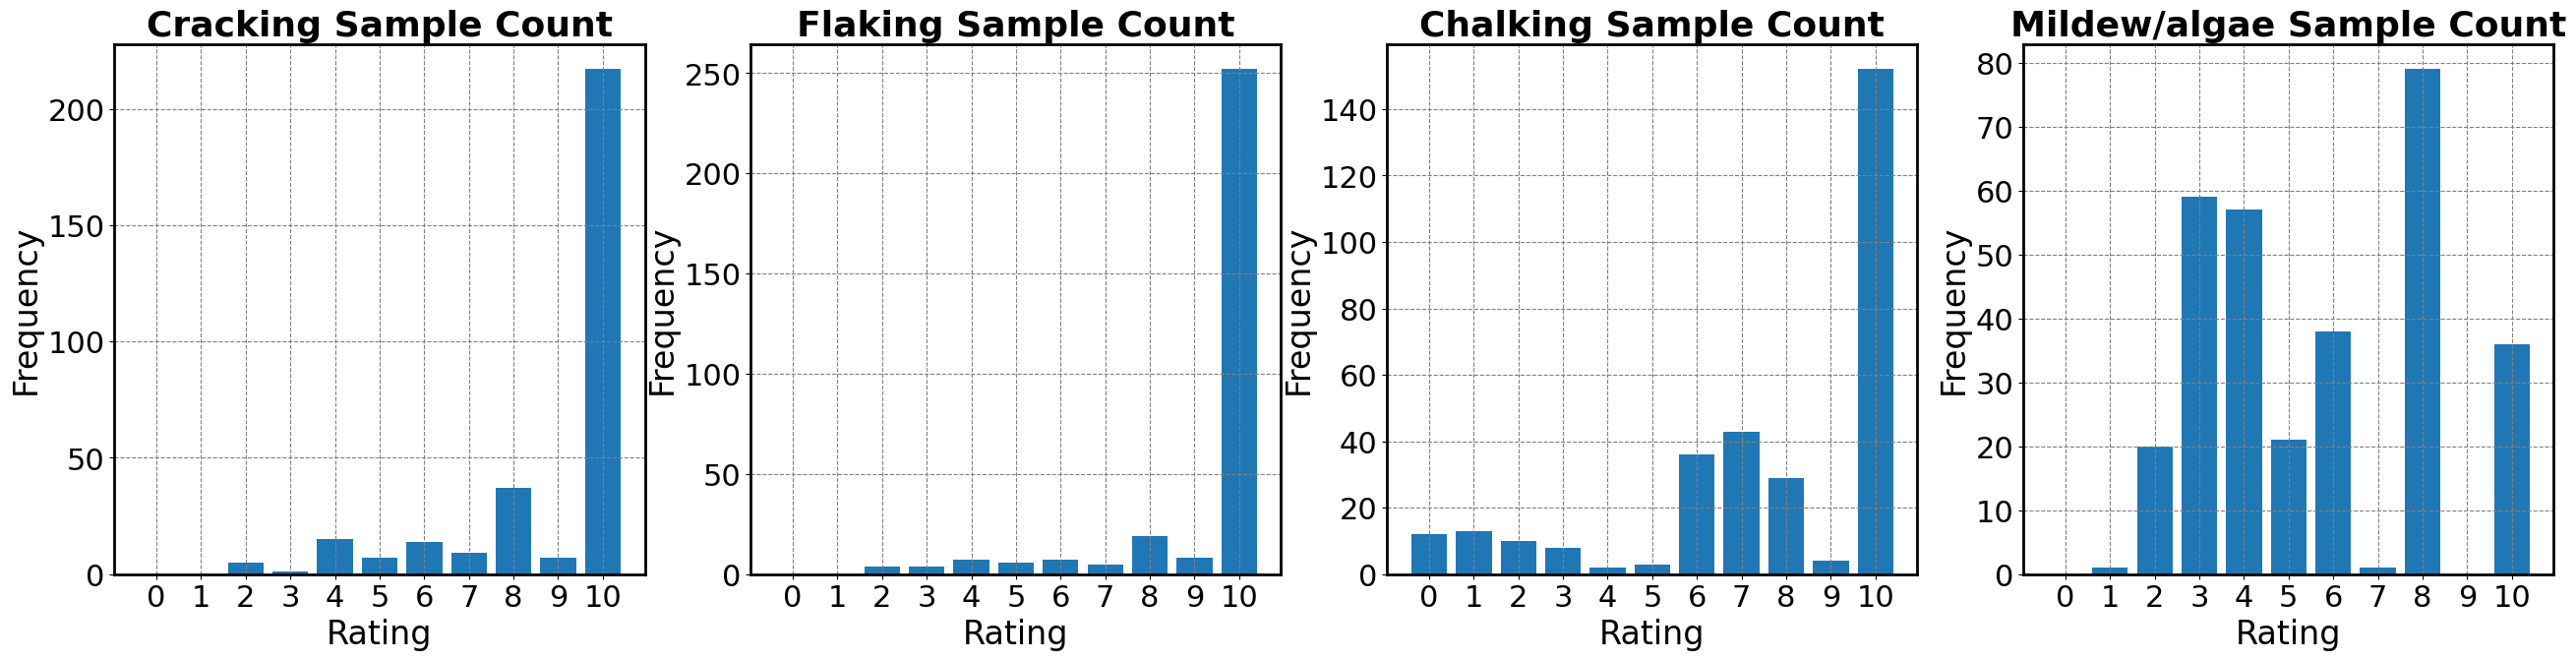

In [307]:
plt.figure(figsize=(32,7))
plt.rc('grid', linestyle="dashed", color='gray')
plt.rc('axes', linewidth=2)
for i, failure in enumerate(PREDICTED_FAILURES):
    plt.subplot(141+i)
    labels = np.arange(11)
    
    # labels, counts = np.unique(train_small_ds.labels[:,i], return_counts=True)
    plt.bar(labels, starter_label_counts[failure], align='center')
    plt.gca().set_xticks(labels)
    # plt.hist(train_small_ds.labels[:,j], bins=[0,1,2,3,4,5,6,7,8,9,10])
    plt.title(failure.capitalize()+" Sample Count",fontweight='bold', fontsize=26)
    plt.xlabel("Rating", fontsize=24)
    plt.ylabel("Frequency", fontsize=24)
    plt.yticks(fontsize=22)
    plt.xticks(fontsize=22)
    plt.grid()
    # plt.savefig("C:/Users/Justin/Downloads/hist_plots.png", dpi=300)

#### Final Data Label Histogram

In [ ]:
new_file_names = compile_samples(include_new=True)
_, final_all_labels, _, _, _, _ = make_sample_splits(new_file_names, split_percents=[1,0,0])

In [ ]:
final_label_counts = {}

for i, failure in enumerate(FAILURES):
    possible_labels = np.arange(11)
    vals, counts = np.unique(final_all_labels[:,i], return_counts=True)
    final_label_counts[failure] = np.zeros_like(possible_labels)
    inds = np.searchsorted(possible_labels, vals)
    final_label_counts[failure][inds] = counts

final_label_counts

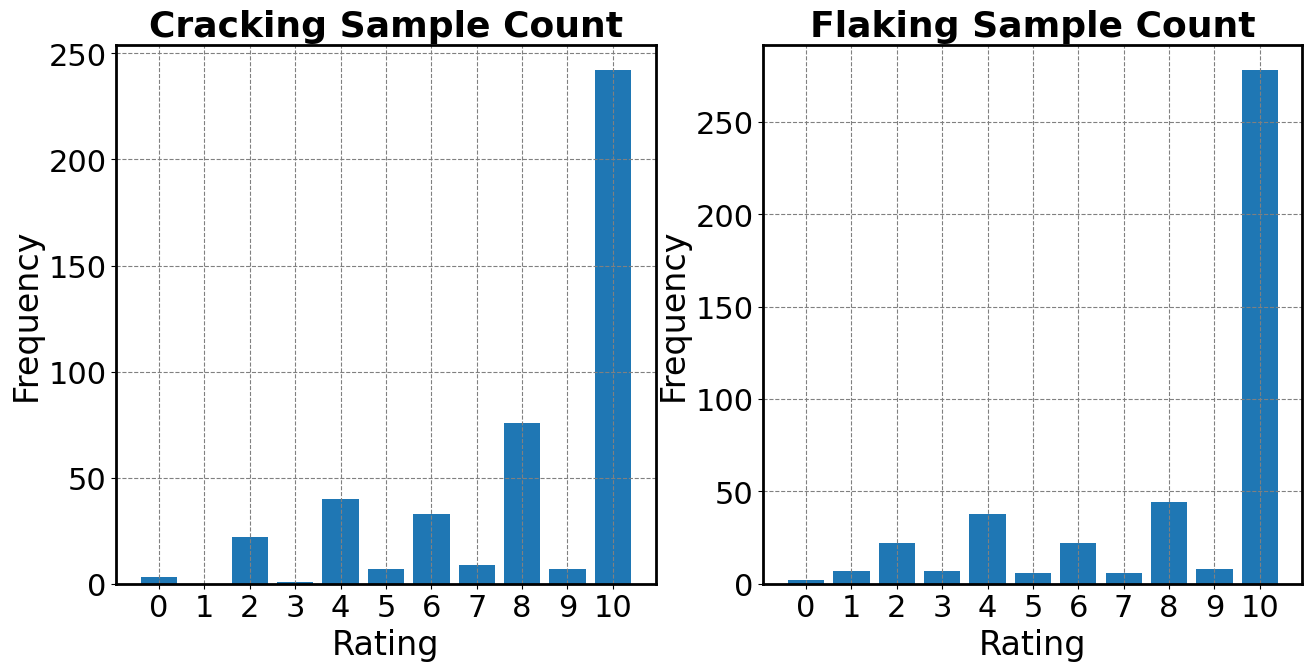

In [310]:
plt.figure(figsize=(32,7))
plt.rc('grid', linestyle="dashed", color='gray')
plt.rc('axes', linewidth=2)
for i, failure in enumerate(PREDICTED_FAILURES):
    plt.subplot(141+i)
    labels = np.arange(11)
    
    # labels, counts = np.unique(train_small_ds.labels[:,i], return_counts=True)
    plt.bar(labels, final_label_counts[failure], align='center')
    plt.gca().set_xticks(labels)
    # plt.hist(train_small_ds.labels[:,j], bins=[0,1,2,3,4,5,6,7,8,9,10])
    plt.title(failure.capitalize()+" Sample Count",fontweight='bold', fontsize=26)
    plt.xlabel("Rating", fontsize=24)
    plt.ylabel("Frequency", fontsize=24)
    plt.yticks(fontsize=22)
    plt.xticks(fontsize=22)
    plt.grid()
    # plt.savefig("C:/Users/Justin/Downloads/hist_plots.png", dpi=300)

#### Stacked Histogram Plot

In [ ]:
stacked_label_counts = {}

for i, failure in enumerate(FAILURES):
    starter_labels = starter_label_counts[failure]
    final_labels = final_label_counts[failure]

    if failure in PREDICTED_FAILURES:
        diff_labels = final_labels - starter_labels
    else:
        diff_labels = final_labels - final_labels # set to 0 if there is no change
    
    stacked_counts = np.vstack((starter_labels,diff_labels))
    stacked_label_counts[failure] = stacked_counts

stacked_label_counts

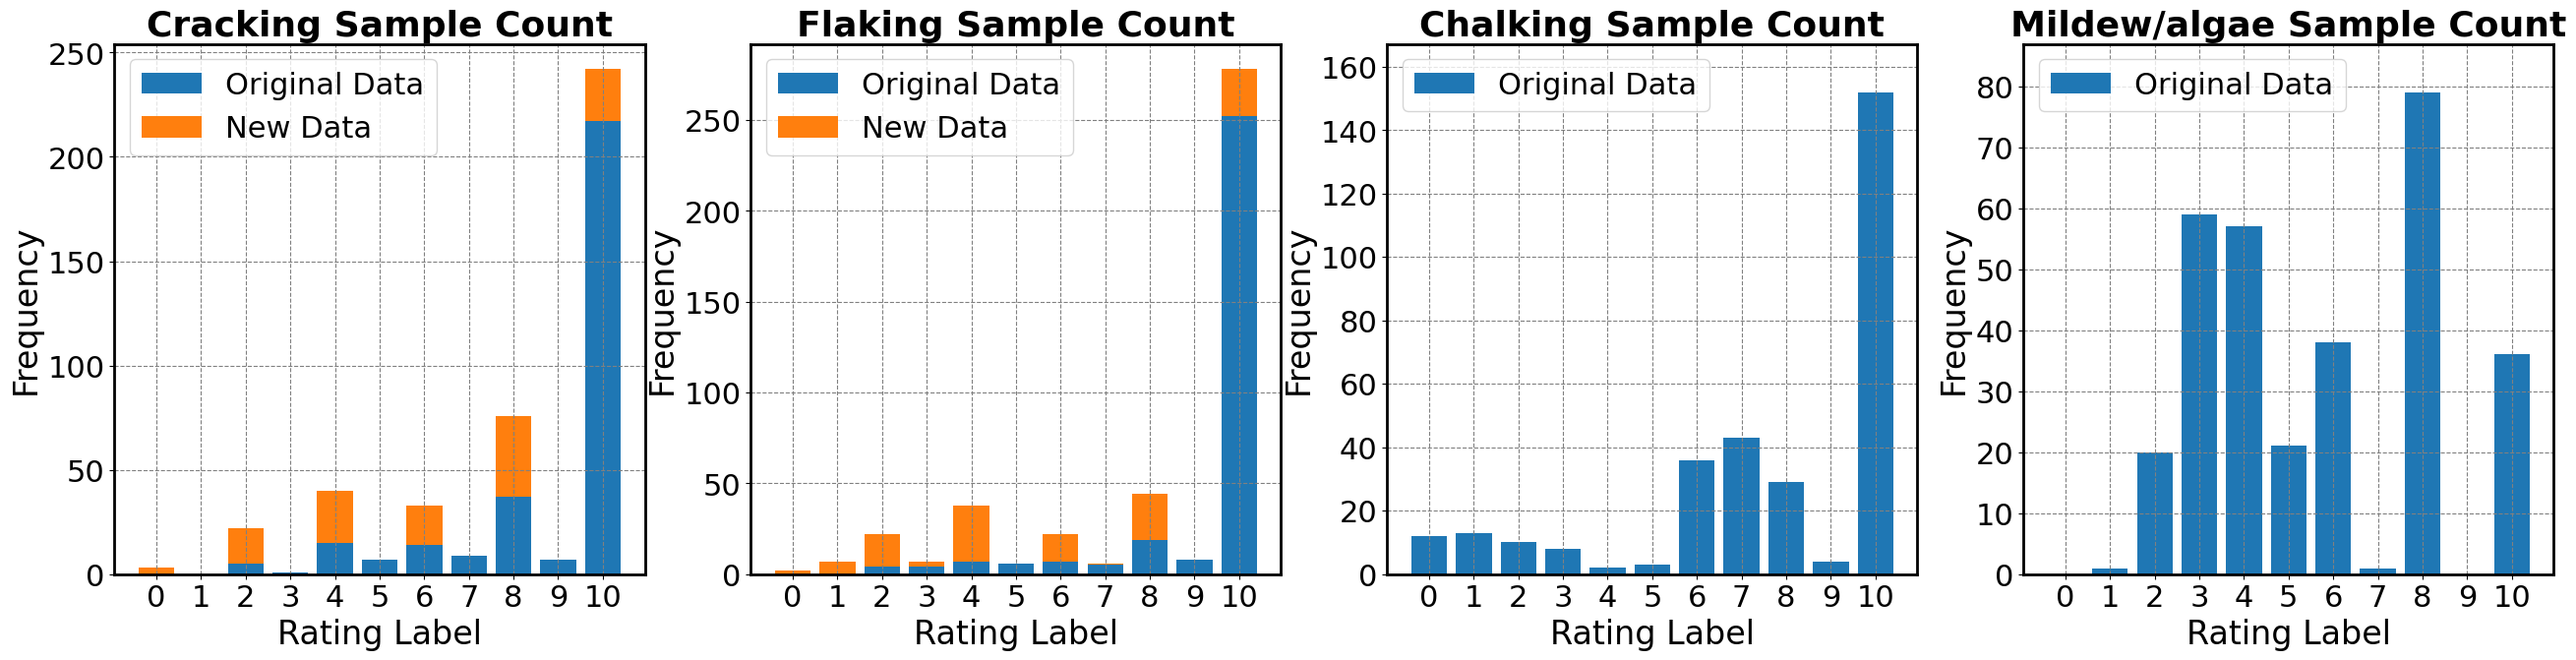

In [319]:
plt.figure(figsize=(32,7))
plt.rc('grid', linestyle="dashed", color='gray')
plt.rc('axes', linewidth=2)
for i, failure in enumerate(["cracking", "flaking", "chalking", "mildew/algae"]):
    plt.subplot(141+i)
    labels = np.arange(11)

    weight_counts = {
        "Original Data": stacked_label_counts[failure][0],
        "New Data": stacked_label_counts[failure][1]
    }
    bottom = np.zeros_like(labels)
    
    # labels, counts = np.unique(train_small_ds.labels[:,i], return_counts=True)

    for data_type, weight_count in weight_counts.items():
        plt.bar(labels, weight_count, align="center", bottom=bottom)
        bottom += weight_count

    # plt.bar(labels, weight_count, align='center')
    plt.gca().set_xticks(labels)
    # plt.hist(train_small_ds.labels[:,j], bins=[0,1,2,3,4,5,6,7,8,9,10])
    plt.title(failure.capitalize()+" Sample Count",fontweight='bold', fontsize=26)
    plt.xlabel("Rating Label", fontsize=24)
    plt.ylabel("Frequency", fontsize=24)
    plt.yticks(fontsize=22)
    plt.xticks(fontsize=22)
    if failure in PREDICTED_FAILURES:
        plt.legend(["Original Data", "New Data"], fontsize=22)
    else:
        max_value = np.max(stacked_label_counts[failure][0])
        plt.legend(["Original Data"], fontsize=22)
        plt.ylim(0, max_value*1.1)
    plt.grid()
    plt.savefig("C:/Users/Justin/Downloads/new_hist_plots.png", dpi=500)

###